<a href="https://colab.research.google.com/github/marquesbmc/Artificial-Intelligence/blob/main/Unet_Unet%2B%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic Segmentation

## 1. Introduction


This is a brief overview about **Deep Learning** image segmentation model using **Tensorflow Keras** and architectures like **U-Net and UNet++**.

Semantic segmentation is one of the main problems in the field of Computer Vision, which needs to deal with the understanding of the scene. Its importance is highlighted by the fact that an increasing number of applications nourish from inferring knowledge from imagery, like self-driving vehicles, human-computer interaction, virtual reality etc.

## 2. What is Semantic Segmentation?

There are various levels of granularity in which the computers can gain an understanding of images. For each of these levels there is a problem defined in the Computer Vision domain, like: 1) image classification; 2) classification with localization; 3) object detection; 4) semantic segmentation and 5) instance segmentation.

Thus, semantic segmentation is a natural step in the progression from coarse to fine inference. First, classification consists of making a prediction for a whole input. The next step is localization / detection, which provide not only the classes but also additional information regarding the spatial location of those classes. Finally, semantic segmentation achieves fine-grained inference by making dense predictions inferring labels for every pixel.

Therefore, the goal of semantic image segmentation is to label **each pixel** of an image with a corresponding **class** of what is being represented.

Unlike other Computer Vision problems, whose outputs are labels and bounding box parameters, semantic segmentation's output is a high resolution image (typically of the same size as input image) in which each pixel is classified to a particular class. Thus it is a pixel level image classification.

<figure>
    <img src="https://miro.medium.com/max/700/1*nXlx7s4wQhVgVId8qkkMMA.png" alt="Semantic Segmentation Image" >
    <figcaption>Semantic Segmentation. Source: https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47</figcaption>
</figure>

Another segmentation case is called instance segmentation wherein along with pixel level classification, we expect the computer to classify each instance of a class separately, giving a unique label to every instance of a particular object in the image.

<figure>
    <img src="https://www.researchgate.net/profile/Dae-Young-Kang/publication/346091812/figure/fig5/AS:979480482955270@1610537753983/Computer-vision-tasks-Adapted-from.png" alt="Computer Vision Tasks" >
    <figcaption>Computer Vision Tasks. Source: https://www.researchgate.net/figure/Computer-vision-tasks-Adapted-from_fig5_346091812</figcaption>
</figure>


## 3. Representing the task



Simply, semantic segmentation goal is to take either a RGB color image (height×width×3) or a grayscale image (height×width×1) and output a segmentation map where each pixel contains a class label represented as an integer (height×width×1).

<figure>
    <img src="https://www.jeremyjordan.me/content/images/2018/05/Screen-Shot-2018-05-17-at-9.02.15-PM.png" alt="Semantic Labels" >
    <figcaption>Semantic Labels. Source: https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47</figcaption>
</figure>

Similar to how we treat standard categorical values, we'll create our target by **one-hot encoding** the class labels - essentially creating an output channel for each of the possible classes. A prediction can be collapsed into a segmentation map by taking the **argmax** of each depth-wise pixel vector. We can easily inspect a target by overlaying it onto the observation.

When we overlay a single channel of our target (or prediction), we refer to this as a mask which illuminates the regions of an image where a specific class is present.

<figure>
    <img src="https://www.jeremyjordan.me/content/images/2018/05/Screen-Shot-2018-05-16-at-9.36.00-PM.png" alt="One-hot encoding" >
    <figcaption>One-hot encoding. Source: https://www.jeremyjordan.me/semantic-segmentation/</figcaption>
</figure>

<figure>
    <img src="https://www.jeremyjordan.me/content/images/2018/05/Screen-Shot-2018-05-16-at-9.36.38-PM.png" alt="Semantic Mask" >
    <figcaption>Semantic Mask. Source: https://www.jeremyjordan.me/semantic-segmentation/</figcaption>
</figure>

## 4. Dataset

####**4.1 Semantic segmentation of aerial imagery**

Humans in the Loop is publishing an open access dataset annotated for a joint project with the Mohammed Bin Rashid Space Center in Dubai, the UAE.

The dataset consists of aerial imagery of Dubai obtained by MBRSC satellites and annotated with pixel-wise semantic segmentation in 6 classes. The total volume of the dataset is 72 images grouped into 8 larger tiles. The classes are:
Building, Land (unpaved area), Road, Vegetation, Water, Unlabeled.

**Acknowledgements**\
The images were segmented by the trainees of the Roia Foundation in Syria.

**Source:** https://www.kaggle.com/humansintheloop/semantic-segmentation-of-aerial-imagery


In [ ]:
# Downloading the dataset and unzipping it.
# Total of 72 image files (8 folders, containing 9 files each)

!wget https://github.com/aislanacf/Dataset/raw/main/ExerciseDataset.zip
!unzip ExerciseDataset.zip

In [ ]:
# Listing the contents of the virtual machine.

!ls -l


In [ ]:
from google.colab import drive

# mount your Google Drive
drive.mount('/content/drive', force_remount=True)

# adjust the path to the location where the models will be written / read
root_path = '/content/drive/My Drive/Colab Notebooks/'


#### 4.2 Data Loader

The dataset is divided into 8 folders corresponding to the original TILES. The storage structure is:

ExerciseDataset/Tile?/images = contains JPG images, from 001 to 009.\
ExerciseDataset/Tile?/masks  = contains PNG masks, from 001 to 009.

The character "?" corresponds to the TILE number (folder), ranging from 1 to 8.

Total of 72 image files (8 folders, containing 9 files each).

In [ ]:
# The COLAB virtual machine already has several packages installed. 
# Therefore, it is only necessary to load into memory those that will be used.

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


In [ ]:
# Defining some variables to access the image files

dataset_path = "/content/ExerciseDataset/"

# Creating folder name list for training
train_folders = sorted([entry for entry in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, entry))])

# As the set of images is small, tiles 2, 4 and 6 folders will be used to evaluate the models.
evaluate_folders = []
evaluate_folders.append(train_folders.pop(1))

print(train_folders)
print(evaluate_folders)

##### 4.2.1 Function to read image pairs (sample and label)

In [ ]:
# Function to read images

def loadImages(datasetPath, folders, normalize=False):
    images = []
    masks = []

    for folder in folders:
        path = os.path.join(datasetPath,folder)

        for entry in sorted(os.listdir(os.path.join(path,'images'))):
            filename = entry[0:-4]

            # OpenCV returns channels in BGR order. Convert to RGB. Only, in this dataset images are organized as BGR
            #img = cv2.cvtColor(cv2.imread(os.path.join(path,'images', filename + '.jpg')), cv2.COLOR_BGR2RGB)
            img = cv2.imread(os.path.join(path,'images', filename + '.jpg'))

            # Masks are png files with 3 channels (with same values): convert to single channel
            mask = cv2.cvtColor(cv2.imread(os.path.join(path,'masks', filename + '.png')), cv2.COLOR_BGR2GRAY)
            
            if img is not None and mask is not None:
                if normalize:
                    img = img / 255.

                images.append(img)
                masks.append(mask)

    return images, masks

##### 4.2.2 Loading images to memory

In [ ]:
# Loading all existing images in Dataset (training) Folders

all_images, all_masks = loadImages(dataset_path, train_folders, True)

print( "Number of images (X): %d " % ( len(all_images) ) )
print( "Number of masks/references (Y): %d " % ( len(all_masks) ) )

#### 4.3 Extracting Image Patches

The images have large and different spatial dimensions (width and height). That is, they are not uniform.

Therefore, it was necessary to extract PATCHES (cutouts from the original image) to reduce and standardize the dimension
of the images that will be used as INPUT of the training.

In [ ]:
'''
PATCH_SIZE defines the measures (spatial dimensions) of the patch.
Working with square patches (H = W). Therefore, a scalar variable is enough.
'''
patch_size = 256

'''
STRIDE will determine the position of the next patch.
A stride smaller than the spatial dimension of the patch determines an overlapping.
12.5% ​​overlap between patches.
'''
stride = patch_size - (patch_size // 8)

# Working with 3 channel images
channels = 3

# Network's input shape
input_shape = (patch_size, patch_size, channels)


##### 4.3.1 Function to extract patches

In [ ]:
# Function: extract_patches_from_list
# -----------------------------------
# Extract patches from a list of images (original and reference)
#
# Input parameters:
#   images = list containing arrays of the original images (h, w, c)
#   references = list containing arrays of reference images (h, w, c)
#   patch_size = patch size (scalar). The shape of the patch is square.
#   stride = displacement to be applied.
#
# Returns: 
#   A, B = Numpy arrays containing the patches for the original image (A) and respective reference (B).

def extract_patches_from_list(images, references, patch_size, stride):
    patch_img = []
    patch_ref = []

    for i in range(0, len(images)):
        xTemp, yTemp = extract_patches(images[i], references[i], patch_size, stride)

        patch_img += xTemp
        patch_ref += yTemp

    return np.array(patch_img), np.array(patch_ref)


# Function: extract_patches
# -------------------------
# Extract patches from the original and reference image
#
# Input parameters:
#   image      = array containing the original image (h,w,c)
#   reference  = array containing the reference image (h,w,c)
#   patch_size = patch size (scalar). The shape of the patch is square.
#   stride     = displacement to be applied.
#
# Returns: 
#   A, B = List containing the patches for the original image (A) and Reference (B).
#
def extract_patches(image, reference, patch_size, stride):
    #print(image.shape)

    patch_img = []
    patch_ref = []

    h = image.shape[0] // stride
    w = image.shape[1] // stride

    for m in range(0, h):
        for n in range(0, w):
            #print('M %d, N %d, start %d finish %d , start %d finish %d' % (m, n, m*stride , m*stride+patch_size, n*stride, n*stride+patch_size) )
            if ( (m*stride+patch_size <= image.shape[0]) and (n*stride+patch_size <= image.shape[1]) ): # only if it fits inside the image
                patch_img.append( image[m*stride:m*stride+patch_size,n*stride:n*stride+patch_size,:] )
                patch_ref.append( reference[m*stride:m*stride+patch_size,n*stride:n*stride+patch_size] )

    return patch_img, patch_ref

##### 4.3.2 Extracting training patches

In [ ]:
# Extract training patches
x_patches, y_patches = extract_patches_from_list( all_images, all_masks, patch_size, stride)

print( "Total patches: %d of shapes %s " % ( x_patches.shape[0], x_patches.shape[1:] ) )

#### 4.4 Class Dictionary

In [ ]:
# Class dictionary: for the convertion of gray values into class labels, and class labels into RGB values (for visualization) 

number_of_classes = 6
classes = { "length": number_of_classes,
            "annotations": [
                { "id": 1, "name": "Land (unpaved area)", "gray": 92, "rgb": (132, 41, 246), "rgb_new": (155, 155, 155), "hex": "8429F6" },
                { "id": 2, "name": "Road", "gray": 172, "rgb": (110, 193, 228), "rgb_new": (245, 175, 13), "hex": "6EC1E4" },
                { "id": 3, "name": "Vegetation", "gray": 212, "rgb": (254, 221, 58), "rgb_new": (126, 228, 82), "hex": "FEDD3A" },
                { "id": 4, "name": "Water", "gray": 171, "rgb": (226, 169, 41), "rgb_new": (81, 126, 231), "hex": "E2A929" },
                { "id": 5, "name": "Building", "gray": 45, "rgb": (60, 16, 152), "rgb_new": (232, 9, 247), "hex": "3C1098" },
                { "id": 0, "name": "Unlabeled", "gray": 155, "rgb": (155, 155, 155), "rgb_new": (0, 0, 0), "hex": "9B9B9B" }
           ]
}


In [ ]:
# The problem has 6 semantic classes (categories).

# A standard gray image ranges from 0 to 255.
# Specifically, the masks/references in this dataset range from 45 (lower gray) to 
# 212 (upper gray).

# In order to avoid an error in Dense Prediction during training, makes a
# conversion from the gray level to the class ID. Thus, it is as if the gray
# level varies from 0 to 5.

tmp = np.zeros((y_patches.shape[0],) + (256,256), dtype="uint8")

for annotation in classes['annotations']:
    tmp = tmp + ( ( y_patches == annotation['gray'] ) * annotation['id'] )

y_patches = tmp
tmp = []

print(y_patches.shape)

##### 4.4.1 Visualization example

In [ ]:
# Converts the label (gray) images back to RGB so that it can be visualized in color

def labelVisualize(class_dict,field,img):

    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))  # shape = 256,256,3

    for annotation in class_dict['annotations']:
        img_out[ img == annotation[field] ] = annotation['rgb_new']

    return img_out / 255

In [ ]:
# Selects a specific image: shows it and the respective label image

image_index = 7

print('\nPlotting images...')
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20, 20))

ax1.imshow( all_images[image_index] )
ax1.set_title('Image', fontsize=20)
ax1.axis('off')

mask = np.zeros((all_images[image_index].shape[0],all_images[image_index].shape[1]), dtype="uint8")
for annotation in classes['annotations']:
    mask = mask + ( ( all_masks[image_index] == annotation['gray'] ) * annotation['id'] )

ax2.imshow( labelVisualize(classes, 'id', mask ) )
ax2.set_title('Mask (colorized)', fontsize=20)
ax2.axis('off')

mask = []

In [ ]:
# Selects a specific patch: shows it and the respective label image

image_index = 45

print('\nPlotting images...')
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10, 10))

ax1.imshow( x_patches[image_index] )
ax1.set_title('Patch', fontsize=20)
ax1.axis('off')

ax2.imshow( labelVisualize(classes, 'id', y_patches[image_index] ) )
ax2.set_title('Mask (colorized)', fontsize=20)
ax2.axis('off')


In [ ]:
# Transform y_patches shape (N, H, W) into shape (N, H, W, C)
# This is because the data agumentation procedure requires an image to have three dimensions

print(y_patches.shape)
y_patches = np.expand_dims(y_patches, 3)
print(y_patches.shape)


## 5. Splitting the Dataset for Training and Validation

Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. This situation is called **overfitting**. To avoid it, it is common practice when performing a (supervised) machine learning experiment to hold out part of the available data as a valid (test) set X_valid, Y_valid.


#### 5.1 A basic form, without libraries

In [ ]:
# Defining the percentage of the training set to be used as validation
valid_percent = 0.25

# Calculating the boundary (index) between training set and validation.
# The premise is always that X and Y have the same number of elements.
limit = len(x_patches) - int( len(x_patches)*valid_percent )

# Training set
x_train = x_patches[:limit]
y_train = y_patches[:limit]

# Validation set
x_valid = x_patches[limit:]
y_valid = y_patches[limit:]

print( "Number of patches/samples in the training set: %d " % ( len(x_train) ) )
print( "Number of patches/samples in the validation set: %d " % ( len(x_valid) ) )

#### 5.2 A basic form, separating sets at random

In [ ]:
# Defining the percentage of the training set to be used as validation
valid_percent = 0.25

# Calculating the boundary (index) between training set and validation.
# The premise is always that X and Y have the same number of elements.
limit = len(x_patches) - int( len(x_patches)*valid_percent )

# Building a list of indexes from 0 to N, where N corresponds to the number of images (patches).
indexes = [i for i in range(x_patches.shape[0])]

# Generating randomness in the list
import random
random.shuffle(indexes)

# Indexes of the images that will be used for training
indexes_for_train = indexes[:limit]
# ndexes of the images that will be used for validation
indexes_for_valid = indexes[limit:]

# Training set
x_train = x_patches[indexes_for_train]
y_train = y_patches[indexes_for_train]

# Validation set
x_valid = x_patches[indexes_for_valid]
y_valid = y_patches[indexes_for_valid]

'''
The above way work because X_PATCHES and Y_PATCHES are objects of the numpy.ndarray class.
Then, it is possible to use extended slicing.

In the case of lists, you would need to convert numpy.asarray () or
make the item-to-item assignment, such as:
x_train = [ x_patches[i] for i in indexes_for_train ]
'''

print( "Number of patches/samples in the training set: %d " % ( len(x_train) ) )
print( "Number of patches/samples in the validation set: %d " % ( len(x_valid) ) )

#### 5.3 With package scikit-learn

In [ ]:
from sklearn.model_selection import train_test_split

# Defining the percentage of the training set to be used as validation
valid_percent = 0.25

(x_train, x_valid, y_train, y_valid) = train_test_split(x_patches, y_patches, test_size=valid_percent, random_state=1)

print( "Number of patches/samples in the training set: %d " % ( len(x_train) ) )
print( "Number of patches/samples in the validation set: %d " % ( len(x_valid) ) )

#### 5.4 Freeing up memory

In [ ]:
# Freeing up memory

all_images = 0
all_masks = 0
x_patches = 0
y_patches = 0

## 6. Data Augmentation

#### 6.1 Defining the parameters of the image generator


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator
#datagen_args = dict(
#        rotation_range=30, # rotation
#        width_shift_range=0.10, # horizontal shift
#        height_shift_range=0.10, # vertical shift
#        zoom_range=0.25, # zoom
#        horizontal_flip=True, # horizontal flip
#        vertical_flip=True, # vertical flip
#        #brightness_range=[0.8,1.2], # brightness (cannot be used for masks/label images)
#        fill_mode='nearest',
#        cval=0
#)

# Only rotations by 90 degrees
def orthogonal_rot(image):
    return np.rot90(image, np.random.choice([-1, 0, 1]))

# Tranformations for image patches
datagen_args = dict(
        preprocessing_function=orthogonal_rot,
        horizontal_flip=True, # horizontal flip
        vertical_flip=True, # vertical flip
        fill_mode='constant',
        cval=0
)

# Its necessary to provide the same seed and kwargs to the flow method
seed = 1
x_datagen = ImageDataGenerator(**datagen_args)
y_datagen = ImageDataGenerator(**datagen_args)


#### 6.2 Showing the results for specific patches/samples



In [ ]:
# Selects a particular patch

show_index = 20

# Must expand image dimension (inser a first axis), because the flow method expects a batch of images.
x_sample = np.expand_dims( x_train[show_index], 0 )
y_sample = np.expand_dims( y_train[show_index], 0 )

x_iterator = x_datagen.flow(x_sample, seed=seed)
y_iterator = y_datagen.flow(y_sample, seed=seed)

nrows = 2
ncols = 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25,10))

for j in range(ncols):
    my_iterator = next( zip( x_iterator, y_iterator ) )

    ax[0][j].axis('off')
    ax[0][j].imshow(my_iterator[0][0])
    ax[1][j].axis('off')
    ax[1][j].imshow( labelVisualize(classes, 'id', my_iterator[1][0]) )


In [ ]:
# Shows the effect on some number of patches

numberOfSamples = 3

x_samples = x_train[0:numberOfSamples]
y_samples = y_train[0:numberOfSamples]

x_iterator = x_datagen.flow(x_samples, seed=seed)
y_iterator = y_datagen.flow(y_samples, seed=seed)

nrows = 2
ncols = 20
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,5))

for j in range(ncols):
    my_iterator = next( zip( x_iterator, y_iterator ) )

    ax[0][j].axis('off')
    ax[0][j].imshow(my_iterator[0][0])
    ax[1][j].axis('off')
    ax[1][j].imshow( labelVisualize(classes, 'id', my_iterator[1][0]) )


## 6. U-Net

The U-net architecture is as shown below. It consists of contraction path (encoder step) and expansion path (decoder step). 

At contraction path, block convolution are formed by two times of 3×3 Conv and 2×2 max pooling. This encoder step can help to extract more advanced features, but it also reduce the size of feature maps.

At expansion path, consecutive of 2×2 Up-conv and two times of 3×3 Conv are done to recover the size of segmentation map. However, the above process reduces the “where” though it increases the “what”. That means, we can get advanced features, but we also loss the localization information.

Thus, after each up-conv, we also have concatenation of feature maps (gray arrows) that are with the same level. This helps to give the localization information from contraction path to expansion path.

At the end, 1×1 conv to map the feature map size from 64 to "N", where "N" is the number of classes.

Reference: https://towardsdatascience.com/review-u-net-biomedical-image-segmentation-d02bf06ca760

![figure 1](https://yann-leguilly.gitlab.io/img/unet_1/figure_1.png)

### 6.1. Implementation


In [ ]:
# Import libraries
from tensorflow.keras.layers import Input, Activation, Dense, Conv2D, MaxPool2D, Dropout, concatenate, UpSampling2D, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score


In [ ]:
def unet(input_shape, n_classes):
# U-Net architecture

    input_img = Input(input_shape)

    # Contract stage
    f1 = 64
    b1conv1 = Conv2D(f1 , (3 , 3) , activation='relu' , padding='same', name = 'b1conv1')(input_img)
    b1conv2 = Conv2D(f1 , (3 , 3) , activation='relu' , padding='same', name = 'b1conv2')(b1conv1)

    pool1 = MaxPool2D((2 , 2), name = 'pooling1')(b1conv2)

    b2conv1 = Conv2D(f1*2 , (3 , 3) , activation='relu' , padding='same', name = 'b2conv1')(pool1)
    b2conv2 = Conv2D(f1*2 , (3 , 3) , activation='relu' , padding='same', name = 'b2conv2')(b2conv1)

    pool2 = MaxPool2D((2 , 2), name = 'pooling2')(b2conv2)

    b3conv1 = Conv2D(f1*4 , (3 , 3) , activation='relu' , padding='same', name = 'b3conv1')(pool2)
    b3conv2 = Conv2D(f1*4 , (3 , 3) , activation='relu' , padding='same', name = 'b3conv2')(b3conv1)

    pool3 = MaxPool2D((2 , 2), name = 'pooling3')(b3conv2)

    b4conv1 = Conv2D(f1*8 , (3 , 3) , activation='relu' , padding='same', name = 'b4conv1')(pool3)
    b4conv2 = Conv2D(f1*8 , (3 , 3) , activation='relu' , padding='same', name = 'b4conv2')(b4conv1)

    pool4 = MaxPool2D((2 , 2), name = 'pooling4')(b4conv2)

    b5conv1 = Conv2D(f1*16 , (3 , 3) , activation='relu' , padding='same', name = 'b5conv1')(pool4)
    b5conv2 = Conv2D(f1*16 , (3 , 3) , activation='relu' , padding='same', name = 'b5conv2')(b5conv1)

    # Expansion stage
    upsample1 = Conv2D(f1*8, (3 , 3), activation = 'relu', padding = 'same', name = 'upsampling1')(UpSampling2D(size = (2,2))(b5conv2))
    concat1 = concatenate( [upsample1,b4conv2] )
    b6conv1 = Conv2D(f1*8 , (3 , 3) , activation='relu' , padding='same', name = 'b6conv1')(concat1)
    b6conv2 = Conv2D(f1*8 , (3 , 3) , activation='relu' , padding='same', name = 'b6conv2')(b6conv1)

    upsample2 = Conv2D(f1*4, (3 , 3), activation = 'relu', padding = 'same', name = 'upsampling2')(UpSampling2D(size = (2,2))(b6conv2))
    concat2 = concatenate( [upsample2,b3conv2] )
    b7conv1 = Conv2D(f1*4 , (3 , 3) , activation='relu' , padding='same', name = 'b7conv1')(concat2)
    b7conv2 = Conv2D(f1*4 , (3 , 3) , activation='relu' , padding='same', name = 'b7conv2')(b7conv1)

    upsample3 = Conv2D(f1*2, (3 , 3), activation = 'relu', padding = 'same', name = 'upsampling3')(UpSampling2D(size = (2,2))(b7conv2))
    concat3 = concatenate( [upsample3,b2conv2] )
    b8conv1 = Conv2D(f1*2 , (3 , 3) , activation='relu' , padding='same', name = 'b8conv1')(concat3)
    b8conv2 = Conv2D(f1*2 , (3 , 3) , activation='relu' , padding='same', name = 'b8conv2')(b8conv1)

    upsample4 = Conv2D(f1, (3 , 3), activation = 'relu', padding = 'same', name = 'upsampling4')(UpSampling2D(size = (2,2))(b8conv2))
    concat4 = concatenate( [upsample4,b1conv2] )
    b9conv1 = Conv2D(f1 , (3 , 3) , activation='relu' , padding='same', name = 'b9conv1')(concat4)
    b9conv2 = Conv2D(f1 , (3 , 3) , activation='relu' , padding='same', name = 'b9conv2')(b9conv1)

    # Output segmentation
    b9conv3 = Conv2D(f1 , (3 , 3) , activation='relu' , padding='same', name = 'b9conv3')(b9conv2)
    b9conv4 = Conv2D(f1 , (3 , 3) , activation='relu' , padding='same', name = 'b9conv4')(b9conv3)

    output = Conv2D(n_classes,(1,1), activation = 'softmax')(b9conv4)
    return Model(inputs = input_img, outputs = output, name='U-Net')


In [ ]:
# Building the model
model = unet(input_shape, number_of_classes)
model.summary()

## 7. Training

In [ ]:
# Functions for training

def set_number_of_batches(qt_train_samples, qt_valid_samples, batch_size, data_augmentation, number_samples_for_generator=4):
    if data_augmentation:
        train_batchs_qtd = qt_train_samples//number_samples_for_generator
        valid_batchs_qtd = qt_valid_samples//number_samples_for_generator
    else:
        train_batchs_qtd = qt_train_samples//batch_size
        valid_batchs_qtd = qt_valid_samples//batch_size

    return train_batchs_qtd, valid_batchs_qtd

def get_batch_samples(x, y, batch, batch_size, data_augmentation, number_samples_for_generator):

    if data_augmentation:
        x_batch = x[batch * number_samples_for_generator : (batch + 1) * number_samples_for_generator, : , : , :]
        y_batch = y[batch * number_samples_for_generator : (batch + 1) * number_samples_for_generator, : , : , :]

        x_iterator = x_datagen.flow(x_batch, seed=batch)
        y_iterator = y_datagen.flow(y_batch, seed=batch)

        x_batch = np.array([next(x_iterator)[0] for _ in range(batch_size)])
        y_batch = np.array([next(y_iterator)[0] for _ in range(batch_size)])
    else:
        x_batch = x[batch * batch_size : (batch + 1) * batch_size, : , : , :]
        y_batch = y[batch * batch_size : (batch + 1) * batch_size, : , : , :]

    return x_batch, y_batch

def train_unet(net, x_train, y_train, x_valid, y_valid, batch_size, epochs, early_stopping_epochs, early_stopping_delta, filepath, filename, data_augmentation=False, number_samples_for_generator=1):
    print('Start the training...')

    # calculating number of batches
    train_batchs_qtd, valid_batchs_qtd = set_number_of_batches(x_train.shape[0], x_valid.shape[0], batch_size, data_augmentation, number_samples_for_generator)
  
    history_train = []
    history_valid = []
    valid_loss_best_model = float('inf')
    no_improvement_count = 0

    for epoch in range(epochs):
        print('Start epoch ... %d ' %(epoch) )
        # shuffle train set
        x_train, y_train = shuffle(x_train , y_train)

        # TRAINING
        train_loss = np.zeros((1 , 2))
        # mini batches strategy
        for  batch in range(train_batchs_qtd):
            print('Start batch ... %d ' %(batch) )
            x_train_batch, y_train_batch = get_batch_samples(x_train, y_train, batch, batch_size, data_augmentation, number_samples_for_generator)
            train_loss = train_loss + net.train_on_batch(x_train_batch, y_train_batch)

        # Estimating the loss in the training set
        train_loss = train_loss/train_batchs_qtd

        # VALIDATING
        valid_loss = np.zeros((1 , 2))
        # Evaluating the network (model) with the validation set
        for  batch in range(valid_batchs_qtd):
            x_valid_batch, y_valid_batch = get_batch_samples(x_valid, y_valid, batch, batch_size, data_augmentation, number_samples_for_generator)
            valid_loss = valid_loss + net.test_on_batch(x_valid_batch, y_valid_batch)

        # Estimating the loss in the validation set
        valid_loss = valid_loss/valid_batchs_qtd

        # Showing the results
        print("%d [Training loss: %f , Train acc.: %.2f%%][Validation loss: %f , Validation acc.:%.2f%%]" %(epoch , train_loss[0 , 0], 100*train_loss[0 , 1] , valid_loss[0 , 0] , 100 * valid_loss[0 , 1]))
        history_train.append( train_loss )
        history_valid.append( valid_loss )

        # Early Stopping
        if (1-(valid_loss[0 , 0]/valid_loss_best_model)) < early_stopping_delta:
            if no_improvement_count+1 >= early_stopping_epochs:
                print('Early Stopping reached')
                break
            else:
                no_improvement_count = no_improvement_count+1
        else:
            valid_loss_best_model = valid_loss[0 , 0]
            no_improvement_count = 0

            # Saving best model  
            print("Saving the model...")
            net.save(filepath+filename+'.h5')

    return [ history_train, history_valid ]


### 7.1. Setting the hyperparameter values

In [ ]:
batch_size = 16
epochs = 200

# Fixed class weights
#weights = [4, 0.10, 0.25, 0.10, 0.25, 0.30]
weights = [1, 1, 1, 1, 1, 1]

# Early Stop parameters
early_stopping_epochs = 20
early_stopping_delta = 0.0001 # delta improvement equivalent to 0.01%

# Data augmentation parameters
data_augmentation = True
number_samples_for_generator = 4

# Optimizer
adam = Adam(learning_rate = 0.0005, beta_1=0.9)


### 7.2. Training run

In [ ]:
# Compile the model
model.compile(loss = "sparse_categorical_crossentropy", optimizer=adam , metrics=['accuracy'], loss_weights=weights)

filename = 'modelo_unet'

# Start training
#history = train_unet(model, x_train, y_train, x_valid, y_valid, batch_size, epochs, early_stopping_epochs, early_stopping_delta, root_path, filename, data_augmentation, number_samples_for_generator)

# Should run the line above, but to speed up training will train with only 10% of (shuffled) training data
x_train, y_train = shuffle(x_train , y_train)
x_valid, y_valid = shuffle(x_valid , y_valid)
num_train = x_train.shape[0]//10
num_valid = x_valid.shape[0]//10
history = train_unet(model, x_train[0:num_train], y_train[0:num_train], x_valid[0:num_valid], y_valid[0:num_valid], batch_size, epochs, early_stopping_epochs, early_stopping_delta, root_path, filename, data_augmentation, number_samples_for_generator)


#### 7.2.1 Training history graph

In [ ]:
def show_graph_loss_accuracy(history,accuracy_position):
    plt.rcParams['axes.facecolor']='white'
    plt.figure(num=1, figsize=(14,6))

    config = [ { 'title': 'model accuracy', 'ylabel': 'accuracy', 'legend_position': 'upper left', 'index_position': accuracy_position },
               { 'title': 'model loss', 'ylabel': 'loss', 'legend_position': 'upper right', 'index_position': 0 } ]

    for i in range(len(config)):
        
        plot_number = 120 + (i+1)
        plt.subplot(plot_number)
        plt.plot(history[0,:,0,config[i]['index_position']])
        plt.plot(history[1,:,0,config[i]['index_position']])
        plt.title(config[i]['title'])
        plt.ylabel(config[i]['ylabel'])
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc=config[i]['legend_position'])
        plt.tight_layout()

    plt.show()

In [ ]:
show_graph_loss_accuracy(np.asarray(history),1)

#### 7.2.2 Testing the model (on training data)


In [ ]:
# Function to evaluate the model
def Test(model, patch_test):
    result = model.predict(patch_test)
    predicted_class = np.argmax(result, axis=-1)
    return predicted_class

# Function to compute accuracy metrics
def compute_metrics(true_labels, predicted_labels):
    accuracy = 100*accuracy_score(true_labels, predicted_labels)
    f1score = 100*f1_score(true_labels, predicted_labels, average=None)
    recall = 100*recall_score(true_labels, predicted_labels, average=None)
    precision = 100*precision_score(true_labels, predicted_labels, average=None)
    return accuracy, f1score, recall, precision

In [ ]:
# Load the best model (file type .h5)
filename = 'modelo_unet'
model = load_model(root_path + filename + '.h5', compile=False)

In [ ]:
# Test the model using some of the training data
pred_train = Test(model, x_train[0:40])

In [ ]:
# Show the prediction of a specific training patch (3, 4, 5, 7)
index = 7

print('\nPlotting images...')
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15, 15))
ax1.imshow(x_train[index])
ax1.set_title('Patch', fontsize=20)
ax1.axis('off')

ax2.imshow( labelVisualize( classes, 'id', y_train[index][:,:,0] ) )
ax2.set_title('Mask', fontsize=20)
ax2.axis('off')

ax3.imshow( labelVisualize( classes, 'id', pred_train[index] ) )
ax3.set_title('Predict', fontsize=20)
ax3.axis('off')


In [ ]:
# Turn labels into unidimensional vectors for accuracy assessment
true_labels = np.reshape(y_train[0:40], (y_train[0:40].shape[0]* y_train[0:40].shape[1]*y_train[0:40].shape[2]))
predicted_labels = np.reshape(pred_train, (pred_train.shape[0]* pred_train.shape[1]*pred_train.shape[2]))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
print('Confusion  matrix')
print('=================')
print(cm)

# Metrics
metrics = compute_metrics(true_labels, predicted_labels)
print('\nMetrics')
print('=======')
print('Accuracy: ', metrics[0])
print('F1score: ', metrics[1])
print('Recall: ', metrics[2])
print('Precision: ', metrics[3])

## 8. Inference

In [ ]:
# Load the best model (file type .h5)
filename = 'modelo_unet'
model = load_model(root_path + filename + '.h5', compile=False)

In [ ]:
# Loading all existing images in Test Folders
all_images, all_masks = loadImages(dataset_path, evaluate_folders, True)

# Extract test patches
x_test, y_test = extract_patches_from_list( all_images, all_masks, patch_size, stride)

tmp = np.zeros((y_test.shape[0],) + (256,256), dtype="uint8")
for annotation in classes['annotations']:
    tmp = tmp + ( ( y_test == annotation['gray'] ) * annotation['id'] )
y_test = tmp

tmp = []
all_images = []
all_masks = []

print( "Total of test patches/samples: %d of shape %s " % ( x_test.shape[0], y_test.shape[1:] ) )

Total of test patches/samples: 36 of shape (256, 256) 


In [ ]:
# Test the model 
pred_test_unet = Test(model, x_test)
print(pred_test_unet.shape)


(36, 256, 256)


In [ ]:
# Show the predictions on an arbitrary patch

index = 7

print('\nPlotting images...')
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15, 15))
ax1.imshow(x_test[index])
ax1.set_title('Patch', fontsize=20)
ax1.axis('off')

ax2.imshow( labelVisualize( classes, 'id', y_test[index][:,:] ) )
ax2.set_title('Mask', fontsize=20)
ax2.axis('off')

ax3.imshow( labelVisualize( classes, 'id', pred_test_unet[index] ) )
ax3.set_title('Predict', fontsize=20)
ax3.axis('off')


In [ ]:
true_labels = np.reshape(y_test, (y_test.shape[0]* y_test.shape[1]*y_test.shape[2]))
predicted_labels = np.reshape(pred_test_unet, (pred_test_unet.shape[0]* pred_test_unet.shape[1]*pred_test_unet.shape[2]))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
print('Confusion  matrix')
print('=================')
print(cm)

# Metrics
metrics = compute_metrics(true_labels, predicted_labels)
print('\nMetrics')
print('=======')
print('Accuracy: ', metrics[0])
print('F1score: ', metrics[1])
print('Recall: ', metrics[2])
print('Precision: ', metrics[3])

## 9. UNet++

UNet++ is a new general purpose image segmentation architecture for more accurate image segmentation. UNet++ consists of U-Nets of varying depths whose decoders are densely connected at the same resolution via the redesigned skip pathways, which aim to address two key challenges of the U-Net: 
1. unknown depth of the optimal architecture and 
2. the unnecessarily restrictive design of skip connections.

UNet++ uses the Dense block ideas from DenseNet and differs from the original U-Net in three ways:

1. having convolution layers on skip pathways, which bridges the semantic gap between encoder and decoder feature maps.
2. having dense skip connections on skip pathways, which improves gradient flow.
3. having deep supervision, which enables model pruning and improves or in the worst case achieves comparable performance to using only one loss layer.

**Papers:**
1. UNet++: A Nested U-Net Architecture for Medical Image Segmentation.\
Zongwei Zhou, Md Mahfuzur Rahman Siddiquee, Nima Tajbakhsh, and Jianming Liang.
Arizona State University\
Deep Learning in Medical Image Analysis (DLMIA) 2018. (Oral)

2. UNet++: Redesigning Skip Connections to Exploit Multiscale Features in Image Segmentation.\
Zongwei Zhou, Md Mahfuzur Rahman Siddiquee, Nima Tajbakhsh, and Jianming Liang.\
Arizona State University\
IEEE Transactions on Medical Imaging (TMI)

3. End-to-End Change Detection for High Resolution Satellite Images Using Improved UNet++\
Daifeng Peng, Yongjun Zhang and Haiyan Guan\
School of Remote Sensing and Geomatics Engineering\
Remote Sens. 2019, 11, 1382.
URL: https://www.mdpi.com/2072-4292/11/11/1382/htm


![figure 2](https://www.mdpi.com/remotesensing/remotesensing-11-01382/article_deploy/html/images/remotesensing-11-01382-g002.png)

Each convolution layer is preceded by a concatenation layer that fuses the output from the previous convolution layer of the same dense block with the corresponding up-sampled output of the lower dense block.

Formally, input to convolutional layer is: 

![figure 2](https://miro.medium.com/max/627/1*dGm3GAy0grdBn258YYzyfQ.png)

In [ ]:
from keras.regularizers import l2
from keras.layers import Add, BatchNormalization, MaxPooling2D, merge, Conv2DTranspose


In [ ]:
def dice_coef(y_true, y_pred, smooth=1, weight=0.5):
    #dice coefficient
    y_true = y_true[:, :, :, -1]
    y_pred = y_pred[:, :, :, -1]
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + weight * K.sum(y_pred)
    return ((2. * intersection + smooth) / (union + smooth))

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def weighted_cce_dice_loss(y_true,y_pred):
    class_loglosses = K.mean(K.categorical_crossentropy(y_true, y_pred), axis=[0, 1, 2])
    class_weights = [0.01, 0.1, 0.15, 0.15, 0.1, 0.49] #note that the weights can be computed automatically using the training samples
    weighted_cce = K.sum(class_loglosses * K.constant(class_weights))
    return weighted_cce + 0.5 * (dice_coef_loss(y_true, y_pred))

def standard_unit(input_tensor, stage, nb_filter, kernel_size=3, mode='None'):
    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation='selu', name='conv' + stage + '_1',
               kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(1e-4))(input_tensor)
    x0 = x
    x = BatchNormalization(name='bn' + stage + '_1')(x)
    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation='selu', name='conv' + stage + '_2',
               kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization(name='bn' + stage + '_2')(x)
    if mode == 'residual':
        x = Add(name='resi' + stage)([x, x0])

    return x


In [ ]:
def unet_plusplus(input_shape, num_class=1, deep_supervision=False):
    nb_filter = [32, 64, 128, 256, 512]

    mode = 'residual' 
    # Handle Dimension Ordering for different backends
    bn_axis = 3
    inputs = Input(shape=input_shape)
    conv1_1 = standard_unit(inputs, stage='11', nb_filter=nb_filter[0])  # add 要求输入输出维度相同
    pool1 = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)  # (?,128,128,32)

    conv2_1 = standard_unit(pool1, stage='21', nb_filter=nb_filter[1], mode=mode)
    pool2 = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)  # (?,64,64,64)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)  # (?,256,256,64)
    conv1_2 = standard_unit(conv1_2, stage='12', nb_filter=nb_filter[0], mode=mode)  # (?,256,256,32)

    conv3_1 = standard_unit(pool2, stage='31', nb_filter=nb_filter[2], mode=mode)
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = standard_unit(conv2_2, stage='22', nb_filter=nb_filter[1], mode=mode)

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = standard_unit(conv1_3, stage='13', nb_filter=nb_filter[0], mode=mode)  # (?,256,256,32)

    conv4_1 = standard_unit(pool3, stage='41', nb_filter=nb_filter[3], mode=mode)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 =standard_unit(conv3_2, stage='32', nb_filter=nb_filter[2], mode=mode)

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = standard_unit(conv2_3, stage='23', nb_filter=nb_filter[1], mode=mode)

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 =standard_unit(conv1_4, stage='14', nb_filter=nb_filter[0], mode=mode)

    conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4], mode=mode)

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = standard_unit(conv4_2, stage='42', nb_filter=nb_filter[3], mode=mode)

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = standard_unit(conv3_3, stage='33', nb_filter=nb_filter[2], mode=mode)

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = standard_unit(conv2_4, stage='24', nb_filter=nb_filter[1], mode=mode)

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 =standard_unit(conv1_5, stage='15', nb_filter=nb_filter[0], mode=mode)

    nestnet_output_1 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1',
                              kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_2)
    nestnet_output_2 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_2',
                              kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_3)
    nestnet_output_3 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_3',
                              kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_4)
    nestnet_output_4 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_4',
                              kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)
    # using combined loss
    conv_fuse = concatenate([conv1_2, conv1_3, conv1_4, conv1_5], name='merge_fuse', axis=bn_axis)
    nestnet_output_5 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_5',
                              kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv_fuse)


    if deep_supervision:
        model = Model(inputs, [ nestnet_output_1,
                                nestnet_output_2,
                                nestnet_output_3,
                                nestnet_output_4, nestnet_output_5])

        model.compile(optimizer=Adam(lr=1e-4),
                      loss=[weighted_cce_dice_loss, weighted_cce_dice_loss, weighted_cce_dice_loss,
                            weighted_cce_dice_loss, weighted_cce_dice_loss],
                      loss_weights=[0.5, 0.5, 0.75, 0.5, 1.0],
                      metrics=['accuracy']
                      )
       
    else:
        model = Model(inputs, [nestnet_output_4])
        model.compile(optimizer=Adam(lr=1e-4), loss=weighted_cce_dice_loss,
                      metrics=['accuracy'])

    model.summary()
    return model

In [ ]:
'''
When "deep_supervision=True", the outputs of the methods
"net.train_on_batch" and "net.test_on_batch" are a LIST in the format:
['loss', 
'output_1_loss', 'output_2_loss', 'output_3_loss', 'output_4_loss', 'output_5_loss', 
'output_1_accuracy', 'output_2_accuracy', 'output_3_accuracy', 'output_4_accuracy', 'output_5_accuracy'
]

There is a LOSS and an ACCURACY for each of the outputs (5 in this case)
Added to a general LOSS.

When "deep_supervision=False", the outputs of the methods
"net.train_on_batch" and "net.test_on_batch" are a LIST in the format:
['loss', 'accuracy']
'''
def initial_loss(deep_supervision=False):
    if deep_supervision:
        train_loss = np.zeros((1 , 11))
        valid_loss = np.zeros((1 , 11))
    else:
        train_loss = np.zeros((1 , 2))
        valid_loss = np.zeros((1 , 2))
    return train_loss, valid_loss

def show_training_results(deep_supervision, epoch, train_loss, valid_loss):
    if deep_supervision:
        print('==========')
        print("EPOCH %d " %(epoch))
        print("Training Loss: [%f] " %(train_loss[0 , 0]))
        print("Training individual loss: [%f,%f,%f,%f,%f] " %(train_loss[0 , 1],train_loss[0 , 2],train_loss[0 , 3],train_loss[0 , 4],train_loss[0 , 5]))
        print("Training individual accuracy: [%f,%f,%f,%f,%f] " %(100*train_loss[0 , 6],100*train_loss[0 , 7],100*train_loss[0 , 8],100*train_loss[0 , 9],100*train_loss[0 , 10]))
        print(' ')
        print("Valid Loss: [%f] " %(valid_loss[0 , 0]))
        print("Valid individual loss: [%f,%f,%f,%f,%f] " %(valid_loss[0 , 1],valid_loss[0 , 2],valid_loss[0 , 3],valid_loss[0 , 4],valid_loss[0 , 5]))
        print("Valid individual accuracy: [%f,%f,%f,%f,%f] " %(100*valid_loss[0 , 6],100*valid_loss[0 , 7],100*valid_loss[0 , 8],100*valid_loss[0 , 9],100*valid_loss[0 , 10]))
    else:
        print("%d [training loss: %f , Train acc.: %.2f%%][Test loss: %f , Test acc.:%.2f%%]" %(epoch , train_loss[0 , 0], 100*train_loss[0 , 1] , valid_loss[0 , 0] , 100 * valid_loss[0 , 1]))

def train_unet_plusplus(net, x_train, y_train, x_valid, y_valid, batch_size, epochs, early_stopping_epochs, early_stopping_delta, filepath, filename, number_of_class, deep_supervision=True, data_augmentation=False, number_samples_for_generator=1):
    print('Start the training...')

    # calculating number of batches.
    train_batchs_qtd, valid_batchs_qtd = set_number_of_batches(x_train.shape[0], x_valid.shape[0], batch_size, data_augmentation, number_samples_for_generator)
  
    history_train = []
    history_valid = []
    valid_loss_best_model = float('inf')
    no_improvement_count = 0
    for epoch in range(epochs):
        print('Start epoch ... %d ' %(epoch) )
        # Shuffle train set
        x_train, y_train = shuffle(x_train , y_train, random_state = 0)
        train_loss, valid_loss = initial_loss(deep_supervision)


        # TRAINING
        # ========
        # mini batches strategy
        for  batch in range(train_batchs_qtd):
            print('Start batch ... %d ' %(batch) )
            x_train_batch, y_train_batch = get_batch_samples(x_train, y_train, batch, batch_size, data_augmentation, number_samples_for_generator)
            # ONE HOT ENCODING
            y_train_hot = tf.keras.utils.to_categorical( np.squeeze(y_train_batch,3), number_of_class)
            train_loss = train_loss + net.train_on_batch(x_train_batch, y_train_hot)

        # Estimating the loss in the training set
        train_loss = train_loss/train_batchs_qtd


        # VALIDATING
        # Evaluating the network (model) with the validation set
        for  batch in range(valid_batchs_qtd):
            x_valid_batch, y_valid_batch = get_batch_samples(x_valid, y_valid, batch, batch_size, data_augmentation, number_samples_for_generator)
            # ONE HOT ENCODING
            y_valid_hot = tf.keras.utils.to_categorical( np.squeeze(y_valid_batch,3), number_of_class)
            valid_loss = valid_loss + net.test_on_batch(x_valid_batch, y_valid_hot)

        # Estimating the loss in the validation set
        valid_loss = valid_loss/valid_batchs_qtd


        # Showing the results.
        show_training_results(deep_supervision, epoch, train_loss, valid_loss)
        history_train.append( train_loss )
        history_valid.append( valid_loss )

        # Early Stopping
        if (1-(valid_loss[0 , 0]/valid_loss_best_model)) < early_stopping_delta:
            if no_improvement_count+1 >= early_stopping_epochs:
                print('Early Stopping reached')
                break
            else:
                no_improvement_count = no_improvement_count+1
        else:
            valid_loss_best_model = valid_loss[0 , 0]
            no_improvement_count = 0

            # Saving best model  
            print("Saving the model...")
            net.save(filepath+filename+'.h5')

    return [ history_train, history_valid ]
    

In [ ]:
deep_supervision = True
model=unet_plusplus(input_shape,number_of_class,deep_supervision)


In [ ]:
output_layer=model.get_layer('output_5')
print("the output shape is:")
print(output_layer.output_shape)

In [ ]:
# Training
filename = 'modelo_unetpp'
hist = train_unet_plusplus(model, x_train[0:48], y_train[0:48], x_valid[0:16], y_valid[0:16], batch_size, epochs, early_stopping_epochs, early_stopping_delta, root_path, filename, number_of_class, deep_supervision, data_augmentation, number_samples_for_generator)


In [ ]:
show_graph_loss_accuracy(np.asarray(hist),10)

In [ ]:
# load the model (arquivo .h5)
model = load_model(root_path + 'modelo_unetpp.h5', compile=False)

In [ ]:
# Test the model using train data
pred_train = Test(model, x_train[0:48])

print(pred_train.shape)
#print(pred_valid.shape)

In [ ]:
indice = 26
base=0

print('\nPlotting images...')
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15, 15))
ax1.imshow(x_train[indice+base])
ax1.set_title('Patch', fontsize=20)
ax1.axis('off')

ax2.imshow( labelVisualize( classes, 'id', y_train[indice+base][:,:,0] ) )
ax2.set_title('Mask', fontsize=20)
ax2.axis('off')

ax3.imshow( labelVisualize( classes, 'id', pred_train[4][indice] ) )
ax3.set_title('Predict', fontsize=20)
ax3.axis('off')


In [ ]:
img_by_class = []
output = 4
img_by_class.append( ( pred_train[output][indice] == 0 ) )
img_by_class.append( ( pred_train[output][indice] == 1 ) )
img_by_class.append( ( pred_train[output][indice] == 2 ) )
img_by_class.append( ( pred_train[output][indice] == 3 ) )
img_by_class.append( ( pred_train[output][indice] == 4 ) )
img_by_class.append( ( pred_train[output][indice] == 5 ) )

nrows = 1
ncols = 6
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,10))
# generate batch of images
for j in range(ncols):
    ax[j].axis('off')
    ax[j].imshow(img_by_class[j], cmap='gray')

In [ ]:
true_labels = np.reshape(y_train[base:base+48], (y_train[base:base+48].shape[0]* y_train[base:base+48].shape[1]*y_train[base:base+48].shape[2]))
predicted_labels = np.reshape(pred_train[4], (pred_train[4].shape[0]* pred_train[4].shape[1]*pred_train[4].shape[2]))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
print('Confusion  matrix')
print('=================')
print(cm)

# Metrics
metrics = compute_metrics(true_labels, predicted_labels)
print('\nMetrics')
print('=======')
print('Accuracy: ', metrics[0])
print('F1score: ', metrics[1])
print('Recall: ', metrics[2])
print('Precision: ', metrics[3])

## 10. Inference

In [ ]:
# load the model (arquivo .h5)
model = load_model(root_path + 'best_model_unetpp.h5', compile=False)

In [ ]:
# Loading all existing images in Test Folders
all_images, all_masks = loadImages(dataset_path, evaluate_folders, True)

# Extract test patches
x_test, y_test = extract_patches_from_list( all_images, all_masks, patch_size, stride)

tmp = np.zeros((y_test.shape[0],) + (256,256), dtype="uint8")
for annotation in classes['annotations']:
    tmp = tmp + ( ( y_test == annotation['gray'] ) * annotation['id'] )
y_test = tmp
tmp = []
all_images = []
all_masks = []

print( "Total patches for testing: %d of shape %s " % ( x_test.shape[0], y_test.shape[1:] ) )

In [ ]:
# Test the model 
pred_test_unetpp = Test(model, x_test)
print(pred_test_unetpp.shape)

In [ ]:
# Some indexes: [0:36] -> 0, 5, 19
indice = 19

print('\nPlotting images...')
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15, 15))
ax1.imshow(x_test[indice])
ax1.set_title('Patch', fontsize=20)
ax1.axis('off')

ax2.imshow( labelVisualize( classes, 'id', y_test[indice][:,:] ) )
ax2.set_title('Mask', fontsize=20)
ax2.axis('off')

ax3.imshow( labelVisualize( classes, 'id', pred_test_unetpp[4][indice] ) )
ax3.set_title('Predict', fontsize=20)
ax3.axis('off')

In [ ]:
true_labels = np.reshape(y_test, (y_test.shape[0]* y_test.shape[1]*y_test.shape[2]))
predicted_labels = np.reshape(pred_test_unetpp[4], (pred_test_unetpp[4].shape[0]* pred_test_unetpp[4].shape[1]*pred_test_unetpp[4].shape[2]))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
print('Confusion  matrix')
print('=================')
print(cm)

# Metrics
metrics = compute_metrics(true_labels, predicted_labels)
print('\nMetrics')
print('=======')
print('Accuracy: ', metrics[0])
print('F1score: ', metrics[1])
print('Recall: ', metrics[2])
print('Precision: ', metrics[3])

## 11. Comparison

In [ ]:
# Some indexes: [0:36] -> 0, 5, 19
indice = 19

print('\nPlotting images...')
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(20, 15))
ax1.imshow(x_test[indice])
ax1.set_title('Patch', fontsize=20)
ax1.axis('off')

ax2.imshow( labelVisualize( classes, 'id', y_test[indice][:,:] ) )
ax2.set_title('Mask', fontsize=20)
ax2.axis('off')

ax3.imshow( labelVisualize( classes, 'id', pred_test_unet[indice] ) )
ax3.set_title('Predict', fontsize=20)
ax3.axis('off')

ax4.imshow( labelVisualize( classes, 'id', pred_test_unetpp[4][indice] ) )
ax4.set_title('Predict', fontsize=20)
ax4.axis('off')

### modelAlr3-5.h5

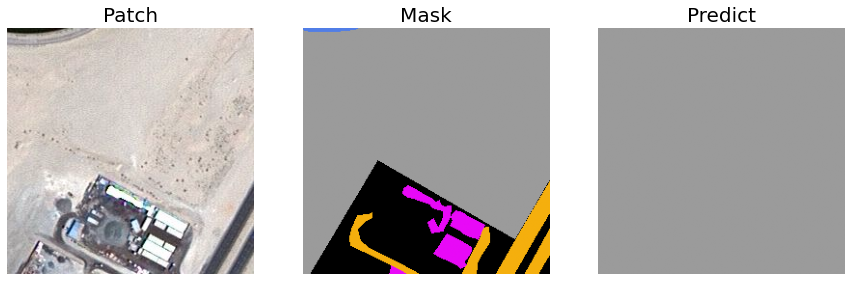


Confusion  matrix
=================
[[      0   34172       0       0       0       0]

 [      0 1557499       0       0       0       0]

 [      0  237080       0       0       0       0]

 [      0  306848       0       0       0       0]

 [      0  221551       0       0       0       0]
 
 [      0  264290       0       0       0       0]]

Metrics
=======
Accuracy:  59.41387176513672

F1score:  [ 0.         74.54040368  0.          0.          0.          0.        ]

Recall:  [  0. 100.   0.   0.   0.   0.]

Precision:  [ 0.         59.41387177  0.          0.          0.          0.        ]


### modelAlr4-5.h5

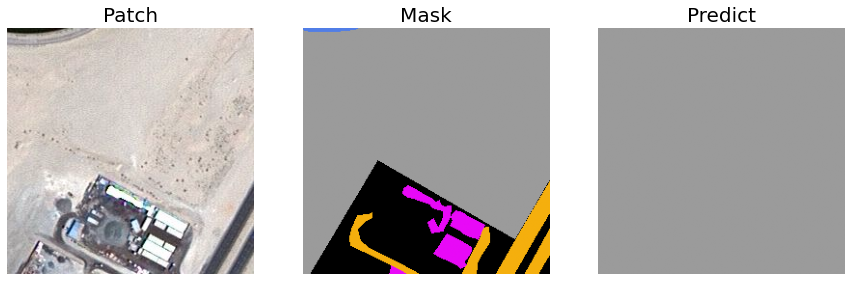


Confusion  matrix
=================
[[      0   34172       0       0       0       0]

 [      0 1557499       0       0       0       0]

 [      0  237080       0       0       0       0]

 [      0  306848       0       0       0       0]

 [      0  221551       0       0       0       0]
 
 [      0  264290       0       0       0       0]]

Metrics
=======
Accuracy:  59.41387176513672

F1score:  [ 0.         74.54040368  0.          0.          0.          0.        ]

Recall:  [  0. 100.   0.   0.   0.   0.]

Precision:  [ 0.         59.41387177  0.          0.          0.          0.        ]

